In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
import gc
pd.set_option('display.max_columns', None)

In [2]:
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for plotting
import matplotlib.pyplot as plt
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import LabelEncoder,Normalizer,StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## for explainer
#from lime import lime_tabular

In [3]:
#to compute information gain
def compute_impurity(feature, impurity_criterion):
    """
    This function calculates impurity of a feature.
    Supported impurity criteria: 'entropy', 'gini'
    input: feature (this needs to be a Pandas series)
    output: feature impurity
    """
    probs = feature.value_counts(normalize=True)
    
    if impurity_criterion == 'entropy':
        impurity = -1 * np.sum(np.log2(probs) * probs)
    elif impurity_criterion == 'gini':
        impurity = 1 - np.sum(np.square(probs))
    else:
        raise ValueError('Unknown impurity criterion')
    return(round(impurity, 3))

def comp_feature_information_gain(df, target, descriptive_feature, split_criterion):
    """
    This function calculates information gain for splitting on 
    a particular descriptive feature for a given dataset
    and a given impurity criteria.
    Supported split criterion: 'entropy', 'gini'
    """
    
    print('target feature:', target)
    print('descriptive_feature:', descriptive_feature)
    print('split criterion:', split_criterion)
            
    target_entropy = compute_impurity(df[target], split_criterion)

    # we define two lists below:
    # entropy_list to store the entropy of each partition
    # weight_list to store the relative number of observations in each partition
    entropy_list = list()
    weight_list = list()
    
    # loop over each level of the descriptive feature
    # to partition the dataset with respect to that level
    # and compute the entropy and the weight of the level's partition
    for level in df[descriptive_feature].unique():
        df_feature_level = df[df[descriptive_feature] == level]
        entropy_level = compute_impurity(df_feature_level[target], split_criterion)
        entropy_list.append(round(entropy_level, 3))
        weight_level = len(df_feature_level) / len(df)
        weight_list.append(round(weight_level, 3))

   # print('impurity of partitions:', entropy_list)
   # print('weights of partitions:', weight_list)

    feature_remaining_impurity = np.sum(np.array(entropy_list) * np.array(weight_list))
    print('remaining impurity:', feature_remaining_impurity)
    
    information_gain = target_entropy - feature_remaining_impurity
    print('information gain:', information_gain)
    
    print('====================')

    return(information_gain)

In [4]:
#a = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
#b = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
a = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
b = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
c =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
d =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
e =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#c = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week3.csv', low_memory=False , encoding='cp1252')
#d = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week4.csv', low_memory=False, encoding='cp1252')
#e =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
#g =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
#h =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')

In [5]:
print(b.shape)
#a.drop(a[a['attackType'] == '---'].index, axis = 0, inplace= True) 
b.drop(b[b['attackType'] == '---'].index, axis = 0, inplace= True)  
c.drop(c[c['attackType'] == '---'].index, axis = 0, inplace= True)  
d.drop(d[d['attackType'] == '---'].index, axis = 0, inplace= True)  
#e.drop(e[e['attackType'] == '---'].index, axis = 0, inplace= True)  
b.shape

(10310733, 16)


(1795404, 16)

In [6]:
data_external = pd.concat([c,d,e], axis = 0)
data_external.reset_index(drop= True, inplace= True)

In [7]:
#to Increment attackID values
data_external['attackID'] = data_external['attackID'].apply(lambda x: str(int(x) + 70) if x != '---' else x)

In [8]:
def convert_bytes(df):
    if 'M' in df:
        df = df.split('M')
        df = df[0].strip()
        df = float(df) * 1000000
    elif 'B' in df:
        df = df.split('B')
        df = df[0].strip()
        df =  float(df) * 1000000000
    else: 
        df =float(df)
    return df

In [9]:
data = pd.concat([a,b,data_external], axis = 0)
data.reset_index(drop= True, inplace= True)
data['Bytes'] = data['Bytes'].apply(lambda x: convert_bytes(x))
data['attackType'] = data['attackType'].apply(lambda x:  'attack' if (x!= '---') else x )
columns = ['Src Pt', 'Dst Pt','Tos','Flows','Packets', 'Bytes']
for i in columns:
    data[i] = pd.to_numeric(data[i]);
del columns
del a,b,c,d,e, data_external
gc.collect()

60

In [10]:
#Converts Hexadecimal value to Binary
def hex_to_binary(hexdata):
    scale = 16 ## equals to hexadecimal
    num_of_bits = 9
    return bin(int(hexdata, scale))[2:].zfill(num_of_bits);
#Converts TCP flags to Binary
def to_Binary(x):
    l = 0
    x = '...' + x
    x = list(x)
    for i in x:
        if (i=='.'):
            x[l]= '0'
        else:
            x[l] = '1'
        l = l +1
    return ''.join(x)
#Converts the 'Flags' column to 9 indiviual columns (manual oneshot encoding)
def flag_convert(df):  
   # df['Flags'] = df['Flags'].apply(lambda x: (list(x)))
   # temp = df['Flags'].apply(lambda x: toBinary(x))
    hex_values = list(df[(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    flag_values = list(df[~(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    binary_values = {}
    for i in hex_values:
         binary_values[i] = (hex_to_binary(i))
    for i in flag_values:
         binary_values[i] = (to_Binary(i))
    temp = df['Flags'].replace(binary_values)
#temp = temp.apply(lambda x: pd.Series(x)) 
    temp = pd.DataFrame(temp.apply(list).tolist())
#temp = pd.DataFrame(temp)
#a = a.iloc[: , 1:]
   # print(temp.head())
    temp.columns = ['N','C','E','U' ,'A','P','R','S','F']
    for i in temp.columns:
        temp[i] = pd.to_numeric(temp[i]);
    temp = temp.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp], axis = 1)
    return df;

In [11]:
#make a IP_pairs 
def make_pair(df):
    ip_pair = df['Src IP Addr'] +'/' +df['Dst IP Addr']
    source_ip = df['Src IP Addr'].unique().tolist()
    destination_ip = df['Dst IP Addr'].unique().tolist()
   # df = df.drop(columns = ['Src IP Addr', 'Dst IP Addr'])
    df.insert(1, ' IP Pair', ip_pair)
    return df

def check_inverse(df):
    list_pairs = df[' IP Pair'].unique()
    tuple_pair = []
    for i in list_pairs:
        tuple_pair.append(tuple((i.split('/'))))
    dic_store = {}
    for i in tuple_pair:
        if (i  not in dic_store.keys()) and (i[::-1] not in dic_store.keys()):
            dic_store[i] = i[0] + '/' +i[1]
    print(len(dic_store.keys()))
    dic_final = {}
    for i in dic_store.keys():
        dic_final[i[0] + '/' +i[1]] = dic_store[i]
        dic_final[i[1] + '/' +i[0]] = dic_store[i]
    df[' IP Pair'] = df[' IP Pair'].map(dic_final)               
    return df

In [12]:
def normalize_IP(df):
    columns = ['sourceIP_feature 1', 'sourceIP_feature 2', 'sourceIP_feature 3', 'sourceIP_feature 4', 'destIP_feature 1',
              'destIP_feature 2', 'destIP_feature 3', 'destIP_feature 4']
    normalized = df[columns]
    print(columns)
    transformed = MinMaxScaler().fit(normalized).transform(normalized)
    transformed = pd.DataFrame(transformed)
    j = 0
    col = {}
    for i in columns:
        col[j] = i
        j=j+1
    transformed = transformed.rename(columns = col)
    transformed = transformed.reset_index()
    for i in columns:
        df[i] = transformed[i].to_numpy()
    return df;

In [13]:
def normalize(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    columns = data.select_dtypes(include=numerics).columns
    normalized = df[columns]
    print(columns)
    transformed = MinMaxScaler().fit(normalized).transform(normalized)
    transformed = pd.DataFrame(transformed)
    j = 0
    col = {}
    for i in columns:
        col[j] = i
        j=j+1
    transformed = transformed.rename(columns = col)
    transformed = transformed.reset_index()
    for i in columns:
        df[i] = transformed[i].to_numpy()
    return df;

In [14]:
def one_shot(df):
    label_encoder = LabelEncoder()
    #df.astype({'attackType': 'str'})
    df['attackType'] = label_encoder.fit_transform(df['attackType'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    
    
    df['Proto'] = label_encoder.fit_transform(df['Proto'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    onehot_encoder1 = OneHotEncoder()
    onehot_encoder1.fit(df.Proto.to_numpy().reshape(-1, 1))
    proto = onehot_encoder1.transform(df.Proto.to_numpy().reshape(-1, 1))
    proto = pd.DataFrame.sparse.from_spmatrix(proto)
    proto.astype('int32')
    proto.columns = label_encoder.classes_
   # print(proto.head(1))
    df = pd.concat([df, proto], axis = 1)
    return df;

In [15]:
def drop_columns(df):
    return df.drop(columns = ['Date first seen', ' IP Pair', 'Flows', 'class', 'attackID','Flags',
                              'attackDescription', 'Src IP Addr', 'Dst IP Addr','Proto'], axis =1)

In [16]:
#Aplit IP address into features, 7 features
def split_to_net(IP_address):
    IP_list = IP_address.split(".")
    needed_len = 7
    needed_len = needed_len - len(IP_list)
    for i in range(0,needed_len,1):
        IP_list.append('0')
    return IP_list
#replace unknown IP address, and convert to columns
def IP_split(df): 
    replace = {"ATTACKER1":"0.0.0.0",
           "ATTACKER2":"0.0.0.0",
           "ATTACKER3":"0.0.0.0",
           "EXT_SERVER": "0.0.0.0.1",
          "OPENSTACK_NET": "0.0.0.0.0.1",
          "DNS": "0.0.0.0.0.0.1"}
    df = df.replace({"Src IP Addr": replace, "Dst IP Addr": replace}, value=None)
    temp_source = df["Src IP Addr"].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
    temp_des = df['Dst IP Addr'].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
   # sourceIP = list(df["Src IP Addr"].unique())
   # destIP = list(df["Dst IP Addr"].unique())
   # sourceIP_values = {}
   # desIP_values = {}
   # for i in sourceIP:
   #      sourceIP_values[i] = (split_to_net(i))
   # for i in destIP:
   #      desIP_values[i] = (split_to_net(i))
    #print(sourceIP_values)
   # print(desIP_values)
#for Source IP
    temp_source = temp_source.apply(lambda x: split_to_net(x) )
    temp_source = pd.DataFrame(temp_source.apply(list).tolist())
    temp_source.columns = ['sourceIP_feature 1','sourceIP_feature 2','sourceIP_feature 3','sourceIP_feature 4' ,
                    'sourceEXT_SERVER','sourceOPENSTACK_NET','sourceDNS']
    for i in temp_source.columns:
        temp_source[i] = pd.to_numeric(temp_source[i]);
    temp_source = temp_source.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_source], axis = 1)
    #for Destination IP
    temp_des = temp_des.apply(lambda x: split_to_net(x) )
    temp_des = pd.DataFrame(temp_des.apply(list).tolist())
    temp_des.columns = ['destIP_feature 1','destIP_feature 2','destIP_feature 3','destIP_feature 4' ,
                    'destEXT_SERVER','destOPENSTACK_NET','destDNS']
    for i in temp_des.columns:
        temp_des[i] = pd.to_numeric(temp_des[i]);
    temp_des = temp_des.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_des], axis = 1)
    return df;

In [17]:
data = make_pair(data)
data = check_inverse(data)

59362


In [18]:
#data = IP_split(data)

In [19]:
data = normalize(data)
data =  one_shot(data) 
#data = normalize_IP(data)

Index(['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Tos'], dtype='object')
['---', 'attack']
[0, 1]
['GRE  ', 'ICMP ', 'IGMP ', 'TCP  ', 'UDP  ']
[0, 1, 2, 3, 4]


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [20]:
data_ig = flag_convert(data)
data_ig = drop_columns(data)

In [21]:
split_criterion = 'entropy'
feature_info_gain = {}
for feature in data_ig.drop(columns='attackType').columns:
    feature_info_gain[feature] = comp_feature_information_gain(data_ig, 'attackType', feature, split_criterion)
feature_info_gain

target feature: attackType
descriptive_feature: Duration
split criterion: entropy
remaining impurity: 0.401493
information gain: 0.640507
target feature: attackType
descriptive_feature: Src Pt
split criterion: entropy
remaining impurity: 0.27205699999999994
information gain: 0.769943
target feature: attackType
descriptive_feature: Dst Pt
split criterion: entropy
remaining impurity: 0.27464799999999995
information gain: 0.767352
target feature: attackType
descriptive_feature: Packets
split criterion: entropy
remaining impurity: 0.48312599999999994
information gain: 0.5588740000000001
target feature: attackType
descriptive_feature: Bytes
split criterion: entropy
remaining impurity: 0.065486
information gain: 0.976514
target feature: attackType
descriptive_feature: Tos
split criterion: entropy
remaining impurity: 0.8962410000000001
information gain: 0.14575899999999997
target feature: attackType
descriptive_feature: GRE  
split criterion: entropy


C:\Users\hp\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


remaining impurity: 1.042
information gain: 0.0
target feature: attackType
descriptive_feature: ICMP 
split criterion: entropy
remaining impurity: 1.032648
information gain: 0.009352000000000027
target feature: attackType
descriptive_feature: IGMP 
split criterion: entropy
remaining impurity: 1.042
information gain: 0.0
target feature: attackType
descriptive_feature: TCP  
split criterion: entropy
remaining impurity: 0.9856520000000001
information gain: 0.056347999999999954
target feature: attackType
descriptive_feature: UDP  
split criterion: entropy
remaining impurity: 0.9867680000000001
information gain: 0.05523199999999995


{'Duration': 0.640507,
 'Src Pt': 0.769943,
 'Dst Pt': 0.767352,
 'Packets': 0.5588740000000001,
 'Bytes': 0.976514,
 'Tos': 0.14575899999999997,
 'GRE  ': 0.0,
 'ICMP ': 0.009352000000000027,
 'IGMP ': 0.0,
 'TCP  ': 0.056347999999999954,
 'UDP  ': 0.05523199999999995}

In [22]:
feature_info_gain = pd.DataFrame.from_dict([feature_info_gain]).transpose()
feature_info_gain = pd.DataFrame(feature_info_gain[0].sort_values(ascending = False))
feature_info_gain.columns = ['entropy']
feature_info_gain

,entropy
Bytes,0.976514
Src Pt,0.769943
Dst Pt,0.767352
Duration,0.640507
Packets,0.558874
Tos,0.145759
TCP,0.056348
UDP,0.055232
ICMP,0.009352
IGMP,0.000000


In [25]:
split_criterion = 'gini'
feature_info_gain1 = {}
for feature in data_ig.drop(columns='attackType').columns:
    feature_info_gain1[feature] = comp_feature_information_gain(data_ig, 'attackType', feature, split_criterion)
feature_info_gain1

target feature: attackType
descriptive_feature: Duration
split criterion: gini
remaining impurity: 0.14406099999999997
information gain: 0.30093900000000007
target feature: attackType
descriptive_feature: Src Pt
split criterion: gini
remaining impurity: 0.133217
information gain: 0.31178300000000003
target feature: attackType
descriptive_feature: Dst Pt
split criterion: gini
remaining impurity: 0.13347900000000001
information gain: 0.311521
target feature: attackType
descriptive_feature: Packets
split criterion: gini
remaining impurity: 0.202782
information gain: 0.24221800000000002
target feature: attackType
descriptive_feature: Bytes
split criterion: gini
remaining impurity: 0.024279000000000002
information gain: 0.420721
target feature: attackType
descriptive_feature: Tos
split criterion: gini
remaining impurity: 0.392797
information gain: 0.052203
target feature: attackType
descriptive_feature: GRE  
split criterion: gini
remaining impurity: 0.445
information gain: 0.0
target featu

{'Duration': 0.30093900000000007,
 'Src Pt': 0.31178300000000003,
 'Dst Pt': 0.311521,
 'Packets': 0.24221800000000002,
 'Bytes': 0.420721,
 'Tos': 0.052203,
 'GRE  ': 0.0,
 'ICMP ': 0.0007480000000000264,
 'IGMP ': 0.0,
 'TCP  ': 0.018392999999999993,
 'UDP  ': 0.019359000000000015}

In [26]:
feature_info_gain1 = pd.DataFrame.from_dict([feature_info_gain1]).transpose()
feature_info_gain1 = pd.DataFrame(feature_info_gain1[0].sort_values(ascending = False), column = ['gini'])
#feature_info_gain1.columns = ['gini']
feature_info_gain1

TypeError: __init__() got an unexpected keyword argument 'column'

In [27]:
#The FIrst 9 features are selected
selected_features = feature_info_gain.index
selected_features = selected_features[0:9]
selected_features

Index(['Bytes', 'Src Pt', 'Dst Pt', 'Duration', 'Packets', 'Tos', 'TCP  ',
       'UDP  ', 'ICMP '],
      dtype='object')

In [20]:
gc.collect()

20

In [21]:
from datetime import datetime
def unix_time(df):
  #  df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x + ':00' if len(x) != 19 else x)
   # df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x[0 : 5 : ] + x[7 : :] if len(x) != 19 else x[0 : 7 : ] + x[9 : :])
    df['Date first seen'] = df['Date first seen'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
    df['Date first seen'] = df['Date first seen'].apply(lambda x: x.timestamp()*1000)
    return df;

In [22]:
def normal_profile(grouped):
    grouped['---'] = unix_time(grouped['---'])
    start_time = int(grouped['---'].head(1)['Date first seen'].values[0])
    end_time = int(grouped['---'].tail(1)['Date first seen'].values[0])
#date_bins = pd.IntervalIndex.from_tuples(
#        [(i, i+3600000) for i in range(start_time, end_time, 3600000)],
#        closed="left")
#date_labels = [f"{i}" for i in range(1, len(date_bins)+1, 1)]
    normal_data = dict(tuple( grouped['---'].groupby( pd.cut(
            grouped['---']['Date first seen'],
               np.arange(start_time, end_time, 3*3600000)))))
    del grouped['---']
    num = []
    for i in grouped_data.keys():
          num.append(len(grouped_data[i]))
    print(min(num))
    num = max(num)
    print(num)
    print(len(grouped.keys()))
    grouped = {**grouped, **normal_data}
    print(len(grouped.keys()))
    return grouped, num;

In [23]:
grouped_data= dict(tuple(data.groupby(['attackID'])))
del data
gc.collect()

0

In [24]:
no_1 = []
no_2 = []
no_3 = []
no_4 = []
for i in grouped_data.keys():
   
    if grouped_data[i]['attackType'].unique()[0] == 0:
        print(f"{i}: {len(grouped_data[i])} : {grouped_data[i]['attackType'].unique()[0]}")
    if grouped_data[i]['attackType'].unique()[0] == 1:
              no_1.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 2:
              no_2.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 3:
              no_3.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 4:
              no_4.append(i)
for i in no_1:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"dos : {len(no_2)}")
for i in no_2:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"pingScan: {len(no_3)}")
for i in no_3:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"portScan : {len(no_4)}")
for i in no_4:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")


---: 7195669 : 0
Attack ID: 1; Lenght of Attack: 7657; Attack Type: 1
Attack ID: 10; Lenght of Attack: 311; Attack Type: 1
Attack ID: 11; Lenght of Attack: 17401; Attack Type: 1
Attack ID: 12; Lenght of Attack: 11526; Attack Type: 1
Attack ID: 13; Lenght of Attack: 513; Attack Type: 1
Attack ID: 14; Lenght of Attack: 13807; Attack Type: 1
Attack ID: 15; Lenght of Attack: 64; Attack Type: 1
Attack ID: 16; Lenght of Attack: 261003; Attack Type: 1
Attack ID: 17; Lenght of Attack: 13338; Attack Type: 1
Attack ID: 18; Lenght of Attack: 295302; Attack Type: 1
Attack ID: 19; Lenght of Attack: 11672; Attack Type: 1
Attack ID: 2; Lenght of Attack: 1927; Attack Type: 1
Attack ID: 20; Lenght of Attack: 11748; Attack Type: 1
Attack ID: 21; Lenght of Attack: 5113; Attack Type: 1
Attack ID: 22; Lenght of Attack: 295; Attack Type: 1
Attack ID: 23; Lenght of Attack: 72788; Attack Type: 1
Attack ID: 24; Lenght of Attack: 466; Attack Type: 1
Attack ID: 25; Lenght of Attack: 201; Attack Type: 1
Attack ID

In [25]:
del no_1
del no_2
del no_3
del no_4
gc.collect()

20

In [26]:
def del_largeInstances(dic, length):
    remove_ID = []
    for i in dic.keys():
        if (i != '---'):
            if(len(dic[i]) >= length):
                remove_ID.append(i)
    print(len(remove_ID))
    removed_attacks = {}
    for i in remove_ID:
        removed_attacks[i] = dic[i]
        del dic[i]
    return dic;

In [27]:
grouped_data = del_largeInstances(grouped_data, 20000)

19


In [28]:
#grouped_data, num = normal_profile(grouped_data)
grouped_data1= {}
for i in grouped_data.keys():
    grouped_data[i] = flag_convert(grouped_data[i])
   # grouped_data[i] =  drop_columns(grouped_data[i])
grouped_data, num = normal_profile(grouped_data)
for i in grouped_data.keys():
   # grouped_data[i] = flag_convert(grouped_data[i])
    grouped_data[i] =  drop_columns(grouped_data[i])

40
19732
73
350


In [29]:
for i in grouped_data.keys():
    #if (grouped_data[i].hasnull())
    print(f'{i} : {grouped_data[i].isnull().values.any()}')

1 : False
10 : False
11 : False
12 : False
13 : False
14 : False
15 : False
17 : False
19 : False
2 : False
20 : False
21 : False
22 : False
24 : False
25 : False
27 : False
29 : False
30 : False
32 : False
33 : False
34 : False
35 : False
36 : False
38 : False
39 : False
40 : False
41 : False
43 : False
47 : False
48 : False
49 : False
5 : False
50 : False
51 : False
52 : False
54 : False
55 : False
56 : False
57 : False
58 : False
61 : False
62 : False
64 : False
65 : False
66 : False
67 : False
68 : False
69 : False
7 : False
70 : False
71 : False
72 : False
73 : False
74 : False
75 : False
76 : False
77 : False
78 : False
79 : False
8 : False
80 : False
81 : False
82 : False
83 : False
84 : False
85 : False
86 : False
87 : False
88 : False
89 : False
90 : False
91 : False
92 : False
(1489536076632, 1489546876632] : False
(1489546876632, 1489557676632] : False
(1489557676632, 1489568476632] : False
(1489568476632, 1489579276632] : False
(1489579276632, 1489590076632] : False
(148959

(1491771676632, 1491782476632] : False
(1491782476632, 1491793276632] : False
(1491793276632, 1491804076632] : False
(1491804076632, 1491814876632] : False
(1491814876632, 1491825676632] : False
(1491825676632, 1491836476632] : False
(1491836476632, 1491847276632] : False
(1491847276632, 1491858076632] : False
(1491858076632, 1491868876632] : False
(1491868876632, 1491879676632] : False
(1491879676632, 1491890476632] : False
(1491890476632, 1491901276632] : False
(1491901276632, 1491912076632] : False
(1491912076632, 1491922876632] : False
(1491922876632, 1491933676632] : False
(1491933676632, 1491944476632] : False
(1491944476632, 1491955276632] : False
(1491955276632, 1491966076632] : False
(1491966076632, 1491976876632] : False
(1491976876632, 1491987676632] : False
(1491987676632, 1491998476632] : False
(1491998476632, 1492009276632] : False
(1492009276632, 1492020076632] : False
(1492020076632, 1492030876632] : False
(1492030876632, 1492041676632] : False
(1492041676632, 149205247

In [30]:
counter = 0
for i in grouped_data.keys():
    if ( len(grouped_data[i]) == 0):
        counter = counter +1;
print(f"Number of Instances which are empty: {counter}")

Number of Instances which are empty: 167


In [31]:
def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100
#Convert to 3D arrays, input dict
def make_array(dic):
    x = []
    y = []
    zero_arrays = []
    for i in dic.keys():
        if ( len(dic[i]) == 0):
            zero_arrays.append(i);
    for i in zero_arrays:
        del dic[i]
    for i in dic.keys():
        x.append(np.array(dic[i].drop(['attackType'],axis = 1)).astype(np.float32))
       # print(f'{i}')
        y.append(dic[i]['attackType'].values[0])
    print(len(y))
    o = []
    features = len(x[1][1])
    #for i in x:
     #   o.append(len(i))
   # print(min(o))
    o = num
    o = roundup(o)
    print(o)
    index = 0
    for i in x:
        l = len(i)
        i = list(i)
        if(o > l):
            l = o-l
            for j in range(0, l, 1):
                i.append([0] * features)
        elif (o<l):
            l = l-o
            i = i[:-l]
        #i = [k = np.array([k]) for l in i for k in l] # Makes array elements an array 
        x[index] = np.array(i).astype(np.float32)
        index = index + 1
    #x = [[i] for i in x]
    return x,y

In [32]:
#Remove columns that were not listed in cfs list
selected_features = ['Bytes', 'Src Pt', 'Dst Pt', 'Duration', 'Packets', 'Tos', 'TCP  ',
       'UDP  ', 'ICMP ', 'attackType']
for i in grouped_data.keys():
    if ( len(grouped_data[i]) != 0):
        grouped_data[i] = grouped_data[i][selected_features]

In [33]:
for i in grouped_data.keys():
    #if (grouped_data[i].hasnull())
    print(f'{i} : {grouped_data[i].isnull().values.any()}')

1 : False
10 : False
11 : False
12 : False
13 : False
14 : False
15 : False
17 : False
19 : False
2 : False
20 : False
21 : False
22 : False
24 : False
25 : False
27 : False
29 : False
30 : False
32 : False
33 : False
34 : False
35 : False
36 : False
38 : False
39 : False
40 : False
41 : False
43 : False
47 : False
48 : False
49 : False
5 : False
50 : False
51 : False
52 : False
54 : False
55 : False
56 : False
57 : False
58 : False
61 : False
62 : False
64 : False
65 : False
66 : False
67 : False
68 : False
69 : False
7 : False
70 : False
71 : False
72 : False
73 : False
74 : False
75 : False
76 : False
77 : False
78 : False
79 : False
8 : False
80 : False
81 : False
82 : False
83 : False
84 : False
85 : False
86 : False
87 : False
88 : False
89 : False
90 : False
91 : False
92 : False
(1489536076632, 1489546876632] : False
(1489546876632, 1489557676632] : False
(1489557676632, 1489568476632] : False
(1489568476632, 1489579276632] : False
(1489579276632, 1489590076632] : False
(148959

(1491976876632, 1491987676632] : False
(1491987676632, 1491998476632] : False
(1491998476632, 1492009276632] : False
(1492009276632, 1492020076632] : False
(1492020076632, 1492030876632] : False
(1492030876632, 1492041676632] : False
(1492041676632, 1492052476632] : False
(1492052476632, 1492063276632] : False
(1492063276632, 1492074076632] : False
(1492074076632, 1492084876632] : False
(1492084876632, 1492095676632] : False
(1492095676632, 1492106476632] : False
(1492106476632, 1492117276632] : False
(1492117276632, 1492128076632] : False
(1492128076632, 1492138876632] : False
(1492138876632, 1492149676632] : False
(1492149676632, 1492160476632] : False
(1492160476632, 1492171276632] : False
(1492171276632, 1492182076632] : False
(1492182076632, 1492192876632] : False
(1492192876632, 1492203676632] : False
(1492203676632, 1492214476632] : False
(1492214476632, 1492225276632] : False
(1492225276632, 1492236076632] : False
(1492236076632, 1492246876632] : False
(1492246876632, 149225767

In [34]:
X,Y = make_array(grouped_data)
del grouped_data
gc.collect()
Y = np.array(Y)
X = np.array(X)

183
19800


In [35]:
unique, counts = np.unique(Y, return_counts=True)
dict(zip(unique, counts))

{0: 110, 1: 73}

In [36]:
def make_4D(arr):
    x = []
    for i in range(0, len(arr),1):
        temp = []
        for j in range(0,len(arr[i]),1):
             temp.append([np.array([k]) for k in arr[i][j]])
        x.append(np.array(temp).astype(np.float32))
    return np.array(x).astype(np.float32)

In [37]:
X = make_4D(X)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, Y_train, Y_test = train_test_split(X,Y , test_size=0.2, random_state=0,  stratify=Y)

In [39]:
del X,Y
gc.collect()

40

In [40]:
unique, counts = np.unique(Y_train, return_counts=True)
dict(zip(unique, counts))

{0: 88, 1: 58}

In [41]:
unique, counts = np.unique(Y_test, return_counts=True)
dict(zip(unique, counts))

{0: 22, 1: 15}

In [42]:
for i in X_train:
    print(f'{np.isnan(i).any()}')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [43]:
nsamples,nx, ny, nz = X_train.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny} \n " )

samples: 146 
 X:19800 
 Y:9 
 


In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Masking, Flatten, Input, Bidirectional, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [45]:
##CNN MODEL

In [46]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
#model_check = ModelCheckpoint("/models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [47]:
model = Sequential()
model.add(Conv2D(64, (2, 2), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation = 'softmax') )
#mod1 = model.compile(optimizer=tf.keras.optimizers.RMSprop(
#   learning_rate=0.1, rho=0.1, momentum=0.0, epsilon=1e-2 , centered=False,
#   name='RMSprop'), loss='sparse_categorical_crossentropy', metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])
#mod = model.fit(X.astype('float32'),Y.astype('float32'), epochs=20, batch_size= 20, verbose=0)des": (2, 10, None),

In [48]:
model.build(input_shape = (nx,ny,nz))
model.output_shape

(None, 5)

In [49]:
#del model, wie_by_epoch

gc.collect()

868

In [50]:
#model.build(input_shape = (nx,ny))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19800, 9, 64)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9900, 4, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 9900, 4, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4950, 2, 64)       0         
_________________________________________________________________
dense (Dense)                (None, 4950, 2, 256)      16640     
_________________________________________________________________
flatten (Flatten)            (None, 2534400)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

In [51]:
wights = model.get_weights()
wights

[array([[[[ 1.04437590e-01, -2.75996402e-02,  1.00214660e-01,
           -1.36689261e-01,  1.31458789e-01, -3.92220467e-02,
            5.42160124e-02,  1.27144545e-01, -9.26781669e-02,
            1.29632205e-01,  6.58937991e-02, -3.19702923e-02,
           -2.25163549e-02,  3.11727822e-03, -2.88254097e-02,
           -7.54909888e-02,  9.92032588e-02,  9.62682366e-02,
           -1.26986057e-02,  5.57510555e-02, -2.25213170e-02,
            1.23963743e-01,  6.93802536e-02,  5.32176942e-02,
           -7.25523680e-02,  1.09778345e-02,  7.43541270e-02,
           -6.19516522e-02, -1.51355818e-01,  1.12435848e-01,
            1.48941994e-01,  1.46987915e-01,  4.44971770e-02,
           -2.40708441e-02,  2.54352689e-02, -2.82086432e-03,
            1.48413569e-01, -8.63075256e-05, -7.49442726e-02,
           -1.47685707e-01,  1.66162401e-02, -1.27547845e-01,
           -3.45949978e-02, -1.03858419e-01, -1.00265518e-01,
           -8.38061795e-02, -1.32875204e-01,  1.35442019e-01,
        

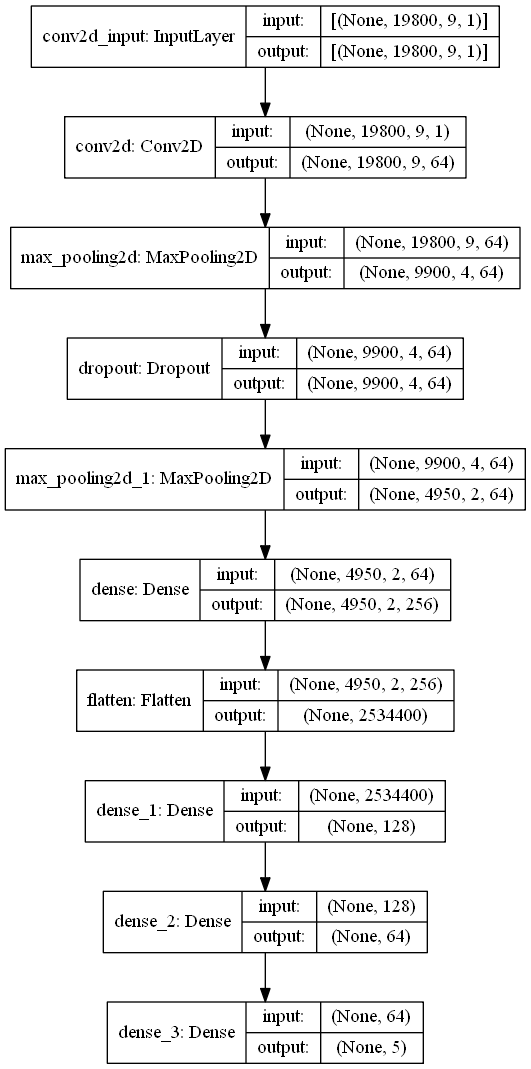

In [52]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [61]:
mod = model.fit(X_train,
               Y_train, epochs=200, batch_size= 32, verbose=2 , 
                callbacks=[callback, print_weights])

Epoch 1/200
5/5 - 33s - loss: 0.0687 - sparse_categorical_accuracy: 0.9726
Epoch 2/200
5/5 - 33s - loss: 0.0499 - sparse_categorical_accuracy: 0.9932
Epoch 3/200
5/5 - 32s - loss: 0.2465 - sparse_categorical_accuracy: 0.9178
Epoch 4/200
5/5 - 31s - loss: 0.1664 - sparse_categorical_accuracy: 0.9521
Epoch 5/200
5/5 - 33s - loss: 0.0431 - sparse_categorical_accuracy: 0.9932
Epoch 6/200
5/5 - 38s - loss: 0.0246 - sparse_categorical_accuracy: 0.9932
Epoch 7/200
5/5 - 34s - loss: 0.0341 - sparse_categorical_accuracy: 0.9932
Epoch 8/200
5/5 - 33s - loss: 0.0173 - sparse_categorical_accuracy: 0.9932
Epoch 9/200
5/5 - 34s - loss: 0.0181 - sparse_categorical_accuracy: 0.9932
Epoch 10/200
5/5 - 30s - loss: 0.0106 - sparse_categorical_accuracy: 0.9932
Epoch 11/200
5/5 - 30s - loss: 0.0096 - sparse_categorical_accuracy: 0.9932
Epoch 12/200
5/5 - 39s - loss: 0.0147 - sparse_categorical_accuracy: 0.9932
Epoch 13/200
5/5 - 30s - loss: 0.0077 - sparse_categorical_accuracy: 0.9932
Epoch 14/200
5/5 - 32

In [62]:
len(wie_by_epoch)

33

In [63]:
#model.set_weights(wie_by_epoch[76])

In [64]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 2s - loss: 0.1402 - sparse_categorical_accuracy: 0.9189


[0.14020046591758728, 0.9189189076423645]

In [65]:
dict(zip(model.metrics_names, scores))

{'loss': 0.14020046591758728,
 'sparse_categorical_accuracy': 0.9189189076423645}

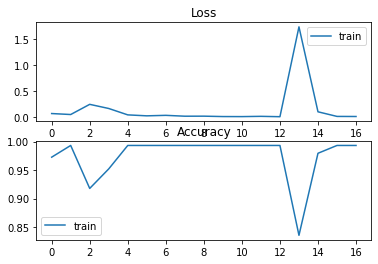

In [66]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [67]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [69]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.918919
Precision: 0.940000
Recall: 0.900000
F1 score: 0.912530


In [70]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.826291
[[22  0]
 [ 3 12]]


In [71]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


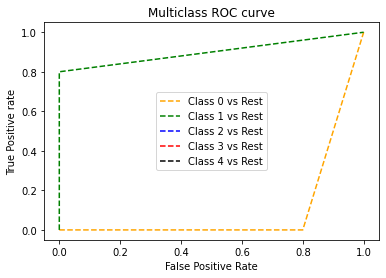

In [72]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [74]:
matrix = confusion_matrix(Y_test, yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 3 12]]


In [75]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       1.00      0.80      0.89        15

    accuracy                           0.92        37
   macro avg       0.94      0.90      0.91        37
weighted avg       0.93      0.92      0.92        37



In [76]:
model.save('./models/IG feature selection/WithoutIP Top9/Binary/CNN')

INFO:tensorflow:Assets written to: ./models/IG feature selection/WithoutIP Top9/Binary/CNN\assets


In [ ]:
#FOr DNN model

In [44]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
#model_check = ModelCheckpoint("/models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [45]:
model = Sequential()
model.add(Flatten(input_shape = X_train.shape[1:], name = 'input'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(5, activation = 'softmax') )
#mod1 = model.compile(optimizer=tf.keras.optimizers.RMSprop(
#   learning_rate=0.1, rho=0.1, momentum=0.0, epsilon=1e-2 , centered=False,
#   name='RMSprop'), loss='sparse_categorical_crossentropy', metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])
#mod = model.fit(X.astype('float32'),Y.astype('float32'), epochs=20, batch_size= 20, verbose=0)

In [46]:
model.build(input_shape = (nx,ny))
model.output_shape

(None, 5)

In [47]:
#del model, wie_by_epoch

gc.collect()

361

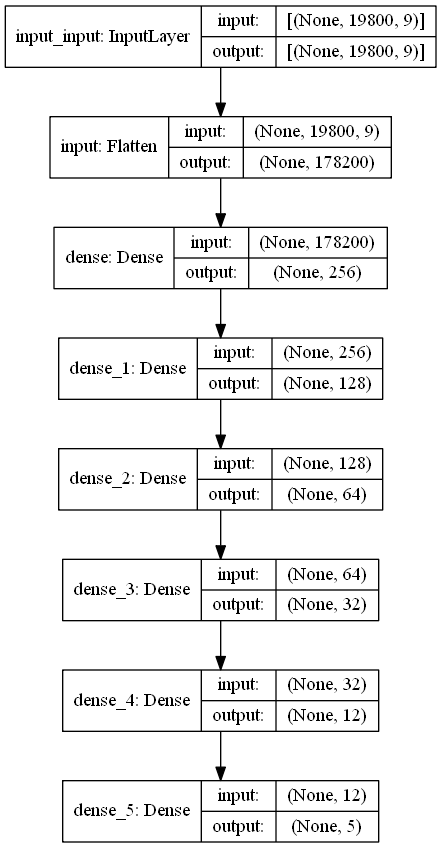

In [48]:
wights = model.get_weights()
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [64]:
mod = model.fit(X_train,
               Y_train, epochs=40, batch_size= 32, verbose=2 , 
                callbacks=[callback, print_weights])

Epoch 1/40
5/5 - 2s - loss: 1.6330e-09 - sparse_categorical_accuracy: 1.0000
Epoch 2/40
5/5 - 2s - loss: 1.6330e-09 - sparse_categorical_accuracy: 1.0000
Epoch 3/40
5/5 - 2s - loss: 1.6330e-09 - sparse_categorical_accuracy: 1.0000
Epoch 4/40
5/5 - 2s - loss: 1.6330e-09 - sparse_categorical_accuracy: 1.0000
Epoch 5/40
5/5 - 2s - loss: 1.6330e-09 - sparse_categorical_accuracy: 1.0000
Epoch 00005: early stopping


In [65]:
#Total Epochs
len(wie_by_epoch)

88

In [66]:
#
#model.set_weights(wie_by_epoch[37])

In [67]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 0s - loss: 1.2883 - sparse_categorical_accuracy: 0.8919


[1.2882566452026367, 0.8918918967247009]

In [68]:
dict(zip(model.metrics_names, scores))

{'loss': 1.2882566452026367, 'sparse_categorical_accuracy': 0.8918918967247009}

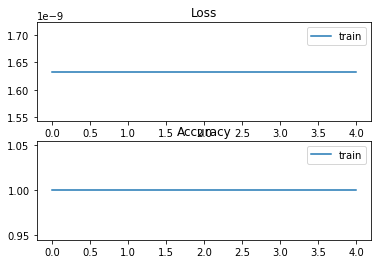

In [69]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [70]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [71]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


In [72]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.891892
Precision: 0.899038
Recall: 0.877273
F1 score: 0.885093


In [73]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.770898
[[21  1]
 [ 3 12]]


In [74]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


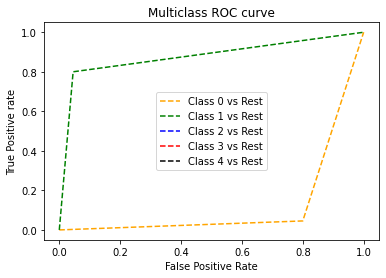

In [75]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [76]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[21  1]
 [ 3 12]]


In [77]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.95      0.91        22
           1       0.92      0.80      0.86        15

    accuracy                           0.89        37
   macro avg       0.90      0.88      0.89        37
weighted avg       0.89      0.89      0.89        37



In [78]:
model.save('./models/IG feature selection/WithoutIP Top9/Binary/DNN')

INFO:tensorflow:Assets written to: ./models/IG feature selection/WithoutIP Top9/Binary/DNN\assets


In [79]:
from keras import backend as K
K.clear_session()

In [80]:
#LSTM

In [81]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
model_check = ModelCheckpoint("./models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [82]:
model = Sequential()
model.add(LSTM(14, activation='relu', return_sequences = True, dropout = 0.1, input_shape = (nx,ny) ))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [83]:
model.build(input_shape = (nx,ny))
model.output_shape

(None, 5)

In [84]:
#del model, wie_by_epoch

gc.collect()

15848

In [85]:
#model.build(input_shape = (nx,ny))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 19800, 14)         1344      
_________________________________________________________________
flatten (Flatten)            (None, 277200)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1386005   
Total params: 1,387,349
Trainable params: 1,387,349
Non-trainable params: 0
_________________________________________________________________


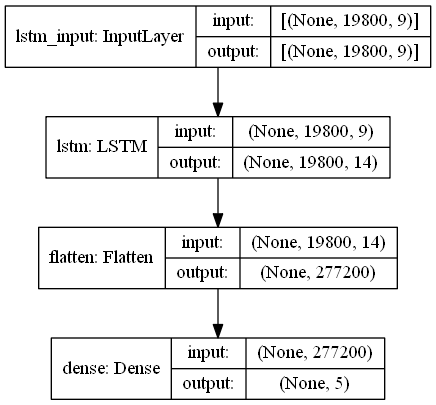

In [86]:
from tensorflow.keras.utils import plot_model
wights = model.get_weights()
plot_model(model, show_shapes=True)

In [91]:
mod = model.fit(X_train,
               Y_train, epochs=60, batch_size= 64, verbose=2 , 
                callbacks=[callback, print_weights, model_check])

Epoch 1/60
3/3 - 36s - loss: 0.0852 - sparse_categorical_accuracy: 0.9726
Epoch 2/60
3/3 - 37s - loss: 0.0829 - sparse_categorical_accuracy: 0.9658
Epoch 3/60
3/3 - 34s - loss: 0.1014 - sparse_categorical_accuracy: 0.9589
Epoch 4/60
3/3 - 35s - loss: 0.1907 - sparse_categorical_accuracy: 0.9452
Epoch 5/60
3/3 - 34s - loss: 0.0759 - sparse_categorical_accuracy: 0.9726
Epoch 6/60
3/3 - 34s - loss: 0.0665 - sparse_categorical_accuracy: 0.9795
Epoch 7/60
3/3 - 35s - loss: 0.0766 - sparse_categorical_accuracy: 0.9658
Epoch 8/60
3/3 - 36s - loss: 0.0885 - sparse_categorical_accuracy: 0.9726
Epoch 9/60
3/3 - 35s - loss: 0.0946 - sparse_categorical_accuracy: 0.9521
Epoch 10/60
3/3 - 36s - loss: 0.1649 - sparse_categorical_accuracy: 0.9315
Epoch 00010: early stopping


In [92]:
# Number of Epochs
len(wie_by_epoch)

25

In [95]:
# 7
model.set_weights(wie_by_epoch[16])

In [96]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 4s - loss: 0.1239 - sparse_categorical_accuracy: 0.9459


[0.12385458499193192, 0.9459459185600281]

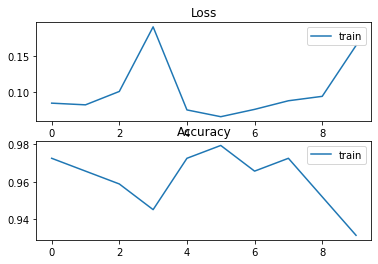

In [97]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [98]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [99]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.945946
Precision: 0.958333
Recall: 0.933333
F1 score: 0.942547


In [100]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.885449
[[22  0]
 [ 2 13]]


In [101]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


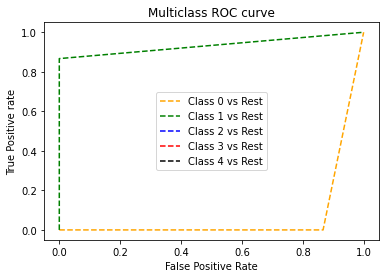

In [102]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [103]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0  0  0]
 [ 2 13  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]


In [104]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      0.87      0.93        15

    accuracy                           0.95        37
   macro avg       0.96      0.93      0.94        37
weighted avg       0.95      0.95      0.95        37



In [105]:
import pickle
#filename = './models/CFS feature selection/With IP_ Top 7/Multi-class/KNN/KNN.sav'
model.save('./models/IG feature selection/WithoutIP Top9/Binary/LSTM')

INFO:tensorflow:Assets written to: ./models/IG feature selection/WithoutIP Top9/Binary/LSTM\assets


In [106]:
from keras import backend as K
K.clear_session()

In [178]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
model_check = ModelCheckpoint("./models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [179]:
model = Sequential()
model.add(SimpleRNN(12, input_shape=(nx, ny), return_sequences = True, activation='relu'))
model.add(Flatten())
model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [180]:
model.build(input_shape = (nx,ny))
model.output_shape

(None, 5)

In [177]:
del model, wie_by_epoch

gc.collect()

68097

In [181]:
#model.build(input_shape = (nx,ny))
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 19800, 12)         264       
_________________________________________________________________
flatten_4 (Flatten)          (None, 237600)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1188005   
Total params: 1,188,269
Trainable params: 1,188,269
Non-trainable params: 0
_________________________________________________________________


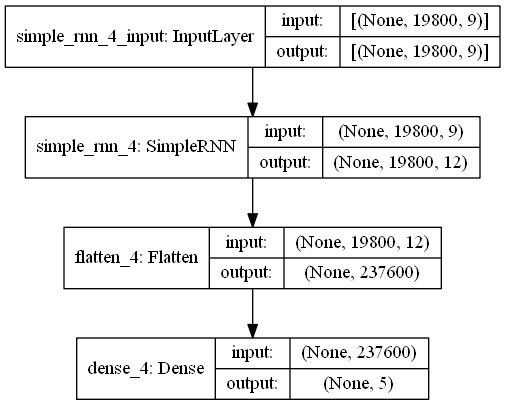

In [182]:
from tensorflow.keras.utils import plot_model
wights = model.get_weights()
plot_model(model, show_shapes=True)

In [183]:
mod = model.fit(X_train,
               Y_train, epochs=60, batch_size= 32, verbose=2 , 
                callbacks=[callback, print_weights, model_check])

Epoch 1/60
5/5 - 40s - loss: 11.3485 - sparse_categorical_accuracy: 0.6233
Epoch 2/60
5/5 - 37s - loss: 0.8972 - sparse_categorical_accuracy: 0.8699
Epoch 3/60
5/5 - 37s - loss: 6.9692 - sparse_categorical_accuracy: 0.7329
Epoch 4/60
5/5 - 36s - loss: 1.8662 - sparse_categorical_accuracy: 0.9452
Epoch 5/60
5/5 - 26s - loss: 0.6005 - sparse_categorical_accuracy: 0.9384
Epoch 6/60
5/5 - 20s - loss: 1.6350 - sparse_categorical_accuracy: 0.8630
Epoch 7/60
5/5 - 23s - loss: 0.0453 - sparse_categorical_accuracy: 0.9932
Epoch 8/60
5/5 - 23s - loss: 0.0218 - sparse_categorical_accuracy: 1.0000
Epoch 9/60
5/5 - 23s - loss: 0.0180 - sparse_categorical_accuracy: 1.0000
Epoch 10/60
5/5 - 22s - loss: 0.0162 - sparse_categorical_accuracy: 1.0000
Epoch 11/60
5/5 - 22s - loss: 0.0148 - sparse_categorical_accuracy: 1.0000
Epoch 12/60
5/5 - 23s - loss: 0.0130 - sparse_categorical_accuracy: 1.0000
Epoch 13/60
5/5 - 23s - loss: 0.0118 - sparse_categorical_accuracy: 0.9932
Epoch 14/60
5/5 - 23s - loss: 0.0

In [184]:
#Number of Epochs
len(wie_by_epoch)

60

In [185]:
#120 +21
#model.set_weights(wie_by_epoch[25])
#mod.history.get('sparse_categorical_accuracy')

In [186]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 1s - loss: 2.6528 - sparse_categorical_accuracy: 0.8919


[2.6528053283691406, 0.8918918967247009]

In [187]:
dict(zip(model.metrics_names, scores))

{'loss': 2.6528053283691406, 'sparse_categorical_accuracy': 0.8918918967247009}

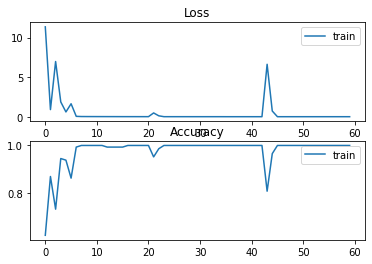

In [188]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [189]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [190]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.891892
Precision: 0.923077
Recall: 0.866667
F1 score: 0.881410


In [191]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.765823
[[22  0]
 [ 4 11]]


In [192]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


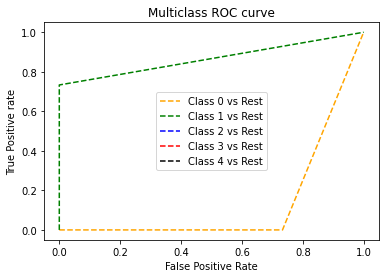

In [193]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [194]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 4 11]]


In [195]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        22
           1       1.00      0.73      0.85        15

    accuracy                           0.89        37
   macro avg       0.92      0.87      0.88        37
weighted avg       0.91      0.89      0.89        37



In [196]:
import pickle
model.save('./models/IG feature selection/WithoutIP Top9/Binary/Simple RNN')

INFO:tensorflow:Assets written to: ./models/IG feature selection/WithoutIP Top9/Binary/Simple RNN\assets


In [ ]:
#MLP

In [197]:
#X = make_4D(X)
nsamples,nx, ny = X_test.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny}" )
X_test = X_test.reshape((nsamples,nx*ny))

samples: 37 
 X:19800 
 Y:9


In [198]:
nsamples,nx, ny = X_train.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny}" )
X_train = X_train.reshape((nsamples,nx*ny))

samples: 146 
 X:19800 
 Y:9


In [199]:
from sklearn.neural_network import MLPClassifier

In [200]:
clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1).fit(X_train, Y_train)
y_pred=clf.predict(X_test)


In [201]:
clf.score(X_test, Y_test)

0.9459459459459459

In [202]:
yhat_classes = y_pred

In [203]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


In [204]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.945946
Precision: 0.958333
Recall: 0.933333
F1 score: 0.942547


In [205]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.885449
[[22  0]
 [ 2 13]]


In [206]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


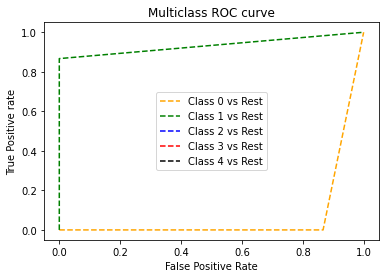

In [207]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [208]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = confusion_matrix(Y_test, yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 2 13]]


In [209]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      0.87      0.93        15

    accuracy                           0.95        37
   macro avg       0.96      0.93      0.94        37
weighted avg       0.95      0.95      0.95        37



In [211]:
import pickle
# save the model to disk
filename = './models/IG feature selection/WithoutIP Top9/Binary/MLP/MLP.sav'
pickle.dump(clf, open(filename, 'wb'))

In [212]:
#DBN model
from dbn.tensorflow import SupervisedDBNClassification

Instructions for updating:
non-resource variables are not supported in the long term


In [215]:
classifier = SupervisedDBNClassification(hidden_layers_structure=[32,32],
                                         learning_rate_rbm=0.00001,
                                         learning_rate=0.02,
                                         n_epochs_rbm=32,
                                         n_iter_backprop=512,
                                         batch_size=32,
                                         activation_function='relu',
                                         dropout_p=0.00001)

In [214]:
del classifier
gc.collect()

112936

In [216]:
classifier.fit(X_train, Y_train)

[START] Pre-training step:
Instructions for updating:
Use `tf.cast` instead.
>> Epoch 1 finished 	RBM Reconstruction error 11548.340820
>> Epoch 2 finished 	RBM Reconstruction error 11548.017578
>> Epoch 3 finished 	RBM Reconstruction error 11547.685547
>> Epoch 4 finished 	RBM Reconstruction error 11547.353516
>> Epoch 5 finished 	RBM Reconstruction error 11547.017578
>> Epoch 6 finished 	RBM Reconstruction error 11546.664062
>> Epoch 7 finished 	RBM Reconstruction error 11546.286133
>> Epoch 8 finished 	RBM Reconstruction error 11545.873047
>> Epoch 9 finished 	RBM Reconstruction error 11545.403320
>> Epoch 10 finished 	RBM Reconstruction error 11544.739258
>> Epoch 11 finished 	RBM Reconstruction error 11543.857422
>> Epoch 12 finished 	RBM Reconstruction error 11542.593750
>> Epoch 13 finished 	RBM Reconstruction error 11540.765625
>> Epoch 14 finished 	RBM Reconstruction error 11537.898438
>> Epoch 15 finished 	RBM Reconstruction error 11533.984375
>> Epoch 16 finished 	RBM Recons

>> Epoch 77 finished 	ANN training loss 0.028064
>> Epoch 78 finished 	ANN training loss 0.027354
>> Epoch 79 finished 	ANN training loss 0.026668
>> Epoch 80 finished 	ANN training loss 0.026007
>> Epoch 81 finished 	ANN training loss 0.025388
>> Epoch 82 finished 	ANN training loss 0.024794
>> Epoch 83 finished 	ANN training loss 0.024239
>> Epoch 84 finished 	ANN training loss 0.023744
>> Epoch 85 finished 	ANN training loss 0.023266
>> Epoch 86 finished 	ANN training loss 0.022797
>> Epoch 87 finished 	ANN training loss 0.022344
>> Epoch 88 finished 	ANN training loss 0.021934
>> Epoch 89 finished 	ANN training loss 0.021523
>> Epoch 90 finished 	ANN training loss 0.021137
>> Epoch 91 finished 	ANN training loss 0.020783
>> Epoch 92 finished 	ANN training loss 0.020434
>> Epoch 93 finished 	ANN training loss 0.020105
>> Epoch 94 finished 	ANN training loss 0.019810
>> Epoch 95 finished 	ANN training loss 0.019509
>> Epoch 96 finished 	ANN training loss 0.019204
>> Epoch 97 finished

>> Epoch 242 finished 	ANN training loss 0.006184
>> Epoch 243 finished 	ANN training loss 0.006151
>> Epoch 244 finished 	ANN training loss 0.006120
>> Epoch 245 finished 	ANN training loss 0.006086
>> Epoch 246 finished 	ANN training loss 0.006056
>> Epoch 247 finished 	ANN training loss 0.006026
>> Epoch 248 finished 	ANN training loss 0.005995
>> Epoch 249 finished 	ANN training loss 0.005964
>> Epoch 250 finished 	ANN training loss 0.005933
>> Epoch 251 finished 	ANN training loss 0.005901
>> Epoch 252 finished 	ANN training loss 0.005870
>> Epoch 253 finished 	ANN training loss 0.005840
>> Epoch 254 finished 	ANN training loss 0.005810
>> Epoch 255 finished 	ANN training loss 0.005766
>> Epoch 256 finished 	ANN training loss 0.005737
>> Epoch 257 finished 	ANN training loss 0.005709
>> Epoch 258 finished 	ANN training loss 0.005667
>> Epoch 259 finished 	ANN training loss 0.005639
>> Epoch 260 finished 	ANN training loss 0.005600
>> Epoch 261 finished 	ANN training loss 0.005572


>> Epoch 406 finished 	ANN training loss 0.002746
>> Epoch 407 finished 	ANN training loss 0.002729
>> Epoch 408 finished 	ANN training loss 0.002718
>> Epoch 409 finished 	ANN training loss 0.002707
>> Epoch 410 finished 	ANN training loss 0.002696
>> Epoch 411 finished 	ANN training loss 0.002685
>> Epoch 412 finished 	ANN training loss 0.002674
>> Epoch 413 finished 	ANN training loss 0.002658
>> Epoch 414 finished 	ANN training loss 0.002648
>> Epoch 415 finished 	ANN training loss 0.002637
>> Epoch 416 finished 	ANN training loss 0.002626
>> Epoch 417 finished 	ANN training loss 0.002616
>> Epoch 418 finished 	ANN training loss 0.002605
>> Epoch 419 finished 	ANN training loss 0.002595
>> Epoch 420 finished 	ANN training loss 0.002584
>> Epoch 421 finished 	ANN training loss 0.002574
>> Epoch 422 finished 	ANN training loss 0.002564
>> Epoch 423 finished 	ANN training loss 0.002549
>> Epoch 424 finished 	ANN training loss 0.002539
>> Epoch 425 finished 	ANN training loss 0.002529


SupervisedDBNClassification(batch_size=32, dropout_p=1e-05,
                            idx_to_label_map={0: 0, 1: 1},
                            l2_regularization=1.0,
                            label_to_idx_map={0: 0, 1: 1}, learning_rate=0.02,
                            n_iter_backprop=512, verbose=True)

In [217]:
# predict probabilities for test set
yhat_probs = classifier.predict(X_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [218]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [219]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.918919
Precision: 0.920807
Recall: 0.910606
F1 score: 0.914943


In [220]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.830015
[[21  1]
 [ 2 13]]


In [221]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


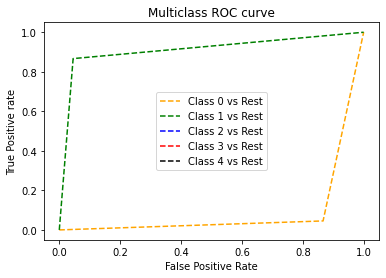

In [222]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [223]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[21  1]
 [ 2 13]]


In [224]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       0.93      0.87      0.90        15

    accuracy                           0.92        37
   macro avg       0.92      0.91      0.91        37
weighted avg       0.92      0.92      0.92        37



In [225]:
classifier.save('./models/IG feature selection/WithoutIP Top9/Binary/DBN/DBN.pkl')